In [1]:
import numpy as np
import math
import os.path
import urllib.request
import gzip
import matplotlib.pyplot as plt
np.random.seed(0)

In [2]:
# MNISTデータセットをダウンロード
def download_mnist_dataset(url):
    filename = './' + os.path.basename(url)
    if os.path.isfile(filename):
        return

    buf = urllib.request.urlopen(url).read()
    with open(filename, mode='wb') as f:
        f.write(buf)

BASE_URL = 'http://yann.lecun.com/exdb/mnist/'
filenames = [
    'train-images-idx3-ubyte.gz',
    'train-labels-idx1-ubyte.gz',
    't10k-images-idx3-ubyte.gz',
    't10k-labels-idx1-ubyte.gz'
]
#[download_mnist_dataset(BASE_URL + filename) for filename in filenames]

In [3]:
def load_file(filename, offset):
    with gzip.open('./' + filename + '.gz', 'rb') as f:
        return np.frombuffer(f.read(), np.uint8, offset=offset)

In [4]:
TX = load_file('train-images-idx3-ubyte', offset=16)
TY = load_file('train-labels-idx1-ubyte', offset=8)

In [5]:
TX

array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)

In [6]:
TY

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

In [7]:
def convertX(X):
    return X.reshape(-1, 1, 28, 28).astype(np.float32) / 255.0

In [8]:
TX = convertX(TX)

In [9]:
def convertY(Y):
    return np.eye(10)[Y]

In [10]:
TY = convertY(TY)

In [11]:
def show_images(X):
    COLUMN = 5
    ROW = (len(X) - 1) // COLUMN + 1
    fig = plt.figure()
    for i in range(len(X)):
        sub = fig.add_subplot(ROW, COLUMN, i + 1)
        sub.axis('off')
        sub.set_title('X[{}]'.format(i))
        plt.imshow(X[i][0], cmap='gray')
    plt.show()

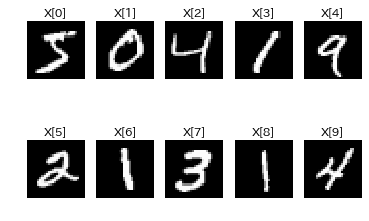

In [12]:
show_images(TX[:10])

In [13]:
#4次元
W1 = np.random.randn( 32,  1, 5, 5)   * math.sqrt(2 / ( 1 * 5 * 5))
W2 = np.random.randn( 64, 32, 5, 5)   * math.sqrt(2 / (32 * 5 * 5))

#2次元
W3 = np.random.randn(200, 64 * 7 * 7) * math.sqrt(2 / (64 * 7 * 7))
W4 = np.random.randn( 10, 200)        * math.sqrt(2 / 200)
b1 = np.zeros(32)
b2 = np.zeros(64)
b3 = np.zeros(200)
b4 = np.zeros(10)

In [14]:
def output_size(input_size, filter_size, stride_size=1, padding_size=0):
    return (input_size - filter_size + 2 * padding_size) // stride_size + 1

# im形式からcol形式へ変換
# -----------------------
#
# im: (画像数 x チャンネル x 高さ x 幅) の形をした変換前画像
# fh: フィルタの高さ
# fw: フィルタの幅
# s: ストライド
# p: パディング
#
# 戻り値: (特徴マップの縦横サイズ x フィルタのサイズ) の形をした行列
def im2col(im, fh, fw, s=1, p=0):
    # 畳み込み後の特徴マップのサイズの計算
    N, IC, IH, IW = im.shape
    OH, OW = output_size(IH, fh, s, p), output_size(IW, fw, s, p)

    # ゼロパディング
    if p > 0:
        im = np.pad(im, [(0,0), (0,0), (p,p), (p,p)], mode='constant')

    # im形式からcol形式へコピー
    col = np.zeros([N, fh * fw, IC, OH, OW])
    for h in range(fh):
        for w in range(fw):
            col[:, h*fw+w] = im[:, :, h:h+(OH*s):s, w:w+(OW*s):s]

    return col.transpose(0, 3, 4, 2, 1).reshape(N * OH * OW, IC * fh * fw)

In [15]:
def convolve(X, W, b, s=1, p=0):
    # 畳み込み後の特徴マップのサイズの計算
    N, IC, IH, IW = X.shape
    K, KC, FH, FW = W.shape
    OH, OW = output_size(IH, FH, s, p), output_size(IW, FW, s, p)

    # 行列積で計算できるようにXとWを変形
    X = im2col(X, FH, FW, s, p)
    W = W.reshape(K, KC * FH * FW).T

    # 畳み込みの計算
    Z = np.dot(X, W) + b

    # 画像数 x チャンネル x 高さ x 幅の並びに戻す
    return Z.reshape(N, OH, OW, K).transpose(0, 3, 1, 2)

In [16]:
def relu(X):
    return np.maximum(0, X)

In [17]:
def max_pooling(X, fh, fw, s):
    # 畳み込み後の特徴マップのサイズの計算
    N, IC, IH, IW = X.shape
    OH, OW = output_size(IH, fh, s), output_size(IW, fw, s)

    # 最大値を選びやすいように形を変更
    X = im2col(X, fh, fw, s).reshape(N * OH * OW * IC, fh * fw)

    # 最大値とそのインデックスを計算
    P  = X.max(axis=1)
    PI = X.argmax(axis=1)

    return P.reshape(N, OH, OW, IC).transpose(0, 3, 1, 2), PI

In [18]:
def softmax(X):
    # 最大値を各要素から引いてexpの計算によるオーバーフローを防ぐ
    N = X.shape[0]
    X = X - X.max(axis=1).reshape(N, -1)

    # Softmax関数の計算
    return np.exp(X) / np.exp(X).sum(axis=1).reshape(N, -1)

In [19]:
def forward(X0):
    # 畳み込み層1
    Z1 = convolve(X0, W1, b1, s=1, p=2)
    A1 = relu(Z1)
    X1, PI1 = max_pooling(A1, fh=2, fw=2, s=2)

    # 畳み込み層2
    Z2 = convolve(X1, W2, b2, s=1, p=2)
    A2 = relu(Z2)
    X2, PI2 = max_pooling(A2, fh=2, fw=2, s=2)

    # 1列に展開
    N = X2.shape[0]
    X2 = X2.reshape(N, -1)

    # 全結合層
    Z3 = np.dot(X2, W3.T) + b3
    X3 = relu(Z3)

    # 出力層
    Z4 = np.dot(X3, W4.T) + b4
    X4 = softmax(Z4)

    return Z1, X1, PI1, Z2, X2, PI2, Z3, X3, X4

In [20]:
def drelu(x):
    return np.where(x > 0, 1, 0)

In [21]:
def delta_output(T, Y):
    return -T + Y

In [22]:
def delta_hidden(Z, D, W):
    return drelu(Z) * np.dot(D, W)

In [23]:
def col2im(col, im_shape, fh, fw, s=1, p=0):
    # 畳み込み後の特徴マップの縦横サイズ
    N, IC, IH, IW = im_shape
    OH, OW = output_size(IH, fh, s, p), output_size(IW, fw, s, p)

    # ストライドとパディングを考慮してim形式用にメモリを確保
    im = np.zeros([N, IC, IH + 2 * p + s - 1, IW + 2 * p + s - 1])

    # col形式からim形式へ戻す。重複した要素は足す
    col = col.reshape(N, OH, OW, IC, fh * fw).transpose(0, 4, 3, 1, 2)
    for h in range(fh):
        for w in range(fw):
            im[:, :, h:h+(OH*s):s, w:w+(OW*s):s] += col[:, h*fw+w]

    # パディング部分は不要なので切り捨てて返す
    return im[:, :, p:IH+p, p:IW+p]

In [24]:
def delta_conv(P, D, W, s, p):
    N, DC, DH, DW = D.shape
    K, KC, FH, FW = W.shape

    # 行列を適切に変形してcol形式を作る
    D = D.transpose(0, 2, 3, 1).reshape(N * DH * DW, DC)
    W = W.reshape(K, KC * FH * FW)
    col_D = np.dot(D, W)

    # col形式からim形式に戻してデルタを計算
    return drelu(P) * col2im(col_D, P.shape, FH, FW, s, p)

In [25]:
def backward_max_pooling(im_shape, PI, D, fh, fw, s):
    N, C, H, W = im_shape
    col_D = np.zeros(N * C * H * W).reshape(-1, fh * fw)
    col_D[np.arange(PI.size), PI] = D.flatten()
    return col2im(col_D, im_shape, fh, fw, s)

In [26]:
def backward(Y, X4, Z3, X2, PI2, Z2, X1, PI1, Z1):
    D4 = delta_output(Y, X4)
    D3 = delta_hidden(Z3, D4, W4)

    D2 = delta_hidden(X2, D3, W3)
    D2 = backward_max_pooling(Z2.shape, PI2, D2, fh=2, fw=2, s=2)

    D1 = delta_conv(X1, D2, W2, s=1, p=2)
    D1 = backward_max_pooling(Z1.shape, PI1, D1, fh=2, fw=2, s=2)

    return D4, D3, D2, D1

In [27]:
def dweight(D, X):
    return np.dot(D.T, X)

In [28]:
def dbias(D):
    return D.sum(axis=0)

In [29]:
def dfilter_weight(X, D, weight_shape):
    K, KC, FH, FW = weight_shape
    N, DC, DH, DW = D.shape

    D = D.transpose(1, 0, 2, 3).reshape(DC, N * DH * DW)
    col_X = im2col(X, FH, FW, 1, 2)
    return np.dot(D, col_X).reshape(K, KC, FH, FW)

# 目的関数のフィルタバイアスでの微分
def dfilter_bias(D):
    N, C, H, W = D.shape
    return D.transpose(1, 0, 2, 3).reshape(C, N * H * W).sum(axis=1)

In [30]:
ETA = 1e-5

In [31]:
def update_parameters(D4, X3, D3, X2, D2, X1, D1, X0):
    global W4, W3, W2, W1, b4, b3, b2, b1

    W4 = W4 - ETA * dweight(D4, X3)
    W3 = W3 - ETA * dweight(D3, X2)
    W2 = W2 - ETA * dfilter_weight(X1, D2, W2.shape)
    W1 = W1 - ETA * dfilter_weight(X0, D1, W1.shape)

    b4 = b4 - ETA * dbias(D4)
    b3 = b3 - ETA * dbias(D3)
    b2 = b2 - ETA * dfilter_bias(D2)
    b1 = b1 - ETA * dfilter_bias(D1)

In [32]:
def train(X0, Y):
    Z1, X1, PI1, Z2, X2, PI2, Z3, X3, X4 = forward(X0)

    D4, D3, D2, D1 = backward(Y, X4, Z3, X2, PI2, Z2, X1, PI1, Z1)

    update_parameters(D4, X3, D3, X2, D2, X1, D1, X0)

In [33]:
EPOCH = 5

In [34]:
def predict(X):
    return forward(X)[-1]

In [35]:
def E(T, X):
    return -(T * np.log(predict(X) + 1e-5)).sum()

In [36]:
BATCH = 1000

In [37]:
%%time
error_all = []
for epoch in range(1, EPOCH + 1):
    # ミニバッチ学習用にランダムなインデックスを取得
    p = np.random.permutation(len(TX))

    # ミニバッチの数分だけデータを取り出して学習
    for i in range(math.ceil(len(TX) / BATCH)):
        indice = p[i*BATCH:(i+1)*BATCH]
        X0 = TX[indice]
        Y  = TY[indice]

        train(X0, Y)
        
        error = E(Y, X0)
        error_all.append(error)
        # ログを残す
        if i % 10 == 0:
            log = '誤差: {:8.4f} ({:2d}エポック {:3d}バッチ目)'
            print(log.format(error, epoch, i))

誤差: 2343.5022 ( 1エポック   0バッチ目)


KeyboardInterrupt: 

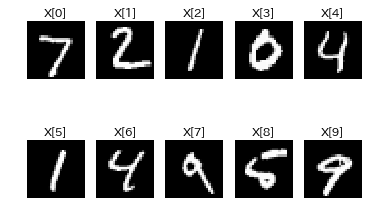

array([3, 6, 1, 0, 2, 1, 4, 0, 6, 7])

In [38]:
testX = load_file('t10k-images-idx3-ubyte', offset=16)
testX = convertX(testX)

# テストデータの最初の10件を表示
show_images(testX[0:10])

# 分類
def classify(X):
    return np.argmax(predict(X), axis=1)

classify(testX[0:10])

In [39]:
%%time
pred = classify(testX[:1000])

CPU times: user 4.33 s, sys: 1.93 s, total: 6.26 s
Wall time: 5.57 s


In [40]:
#load_file('train-labels-idx1-ubyte', offset=8)
testY = load_file('t10k-labels-idx1-ubyte', offset=8)
true = testY[:1000]

In [41]:
from sklearn import metrics

In [42]:
print('acc:{}'.format(metrics.accuracy_score(true, pred)))

acc:0.296


In [43]:
print(metrics.classification_report(true, pred))

              precision    recall  f1-score   support

           0       0.21      0.32      0.25        85
           1       0.72      0.73      0.73       126
           2       0.44      0.33      0.37       116
           3       0.28      0.64      0.39       107
           4       0.34      0.23      0.27       110
           5       0.15      0.11      0.13        87
           6       0.27      0.21      0.24        87
           7       0.22      0.08      0.12        99
           8       0.07      0.11      0.09        89
           9       0.00      0.00      0.00        94

   micro avg       0.30      0.30      0.30      1000
   macro avg       0.27      0.28      0.26      1000
weighted avg       0.29      0.30      0.28      1000



In [44]:
len(error_all)

4

In [45]:
x = np.arange(len(error_all))

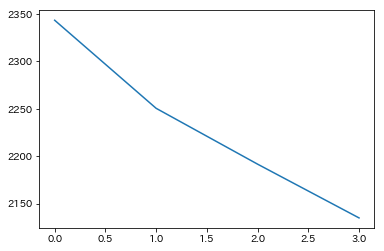

In [46]:
plt.plot(x, error_all)